In [1]:
import numpy as np
import sys 
sys.path.append(r'../../Python Script/')

from sympy import symbols, simplify, derive_by_array
from scipy.integrate import solve_ivp
from xLSINDy import *
from sympy.physics.mechanics import *
from sympy import *
import sympy
import torch
import HLsearch as HL
import matplotlib.pyplot as plt

In [2]:
# System parameters
L1, L2 = 1, 1
m1, m2 = 1, 1
k1, k2 = 0.5, 0.5
g = 9.8

In [3]:
states_dim = 4
states = ()
states_dot = ()
for i in range(states_dim):
    if(i<states_dim//2):
        states = states + (symbols('x{}'.format(i)),)
        states_dot = states_dot + (symbols('x{}_t'.format(i)),)
    else:
        states = states + (symbols('x{}_t'.format(i-states_dim//2)),)
        states_dot = states_dot + (symbols('x{}_tt'.format(i-states_dim//2)),)
print('states are:',states)
print('states derivatives are: ', states_dot)

#Turn from sympy to str
states_sym = states
states_dot_sym = states_dot
states = list(str(descr) for descr in states)
states_dot = list(str(descr) for descr in states_dot)

states are: (x0, x1, x0_t, x1_t)
states derivatives are:  (x0_t, x1_t, x0_tt, x1_tt)


In [4]:
#For friction force
x0 = Symbol(states[0], real=True)
x1 = Symbol(states[1], real=True)
x0_t = Symbol(states[2],real=True)
x1_t = Symbol(states[3],real=True)
q = sympy.Array([x0, x1])
qdot = sympy.Array([x0_t, x1_t])

#True Rayleigh Dissipation function
dummy = Symbol('a', real = True)
R = dummy #0.5*k1*x0_t**2 + 0.5*k2*(x1_t - x0_t)**2 #+ k1*Abs(x0_t) + k2*Abs(x1_t - x0_t)

#friction force
f_forcing = sympy.Matrix(derive_by_array(R, qdot)) 

In [5]:
#for lagrangian
x0 = dynamicsymbols(states[0], real=True)
x1 = dynamicsymbols(states[1], real=True)
x0_t = dynamicsymbols(states[0],1, real=True)
x1_t = dynamicsymbols(states[1],1, real=True)
tau0 = symbols('tau0')
tau1 = symbols('tau1')

#True Lagrangian
L = 0.5*(m1+m2)*L1**2*x0_t**2 + 0.5*m2*L2**2*x1_t**2 + m2*L2**2*x0_t*x1_t*cos(x0)*cos(x1) + m2*L2**2*x0_t*x1_t*sin(x0)*sin(x1) + (m1+m2)*g*L1*cos(x0) + m2*g*L2*cos(x1)

# Lagrange's method
LM = LagrangesMethod(L, [x0,x1])
LM.form_lagranges_equations()
i_forcing = LM.forcing #internal forcing and gravity
e_forcing = sympy.Matrix([tau0-tau1, tau1]) #external generalized force

In [6]:
# Substituting dynamic symbols

i_forcing = i_forcing.subs(x0_t, states_sym[2])
i_forcing = i_forcing.subs(x1_t, states_sym[3])
i_forcing = i_forcing.subs(x0, states_sym[0])
i_forcing = i_forcing.subs(x1, states_sym[1])

M = LM.mass_matrix
M = M.subs(x0, states_sym[0])
M = M.subs(x1, states_sym[1])

In [7]:
# Generating equation of motion
t_forcing = i_forcing + e_forcing - f_forcing
eom = M.inv()*sympy.Matrix(t_forcing)

In [8]:
''' Please copy the string shown to the definition of equation in the function of double pendulum'''
for i in range(len(eom)):
    print('Equation ' + str(i) +': ' + str(eom[i]))
    print('\n')

Equation 0: (2.0*sin(x0)*sin(x1) + 2.0*cos(x0)*cos(x1))*(tau1 + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) - 9.8*sin(x1))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0) - 2.0*(tau0 - tau1 - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) - 19.6*sin(x0))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0)


Equation 1: (1.0*sin(x0)*sin(x1) + 1.0*cos(x0)*cos(x1))*(tau0 - tau1 - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) - 19.6*sin(x0))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0) - 2.0*(tau1 + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) - 9.8*sin(x1))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0)




In [9]:
import time

def torque(t,omega):
    return 1*np.cos(omega*t), 1*np.sin(omega*t)

def doublePendulum(t,y,omega):
    from numpy import sin, cos, sign
    x0,x1,x0_t,x1_t = y
    tau0, tau1 = torque(t, omega)
    x0_tt = (2.0*sin(x0)*sin(x1) + 2.0*cos(x0)*cos(x1))*(tau1 + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) - 9.8*sin(x1))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0) - 2.0*(tau0 - tau1 - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) - 19.6*sin(x0))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0)
    x1_tt =  (1.0*sin(x0)*sin(x1) + 1.0*cos(x0)*cos(x1))*(tau0 - tau1 - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) - 19.6*sin(x0))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0) - 2.0*(tau1 + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) - 9.8*sin(x1))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0)
    return x0_t,x1_t,x0_tt,x1_tt


def generate_data(func, time, init_values, omega):
    sol = solve_ivp(func,[time[0],time[-1]],init_values,t_eval=time, method='LSODA', rtol=1e-10,atol=1e-10, args=[omega])
    return sol.y.T, np.array([func(time[i],sol.y.T[i,:], omega = omega) for i in range(sol.y.T.shape[0])],dtype=np.float64)


In [11]:
#Saving Directory
rootdir = "../../Double Pendulum/Data/Active/"

num_sample = 100
create_data = False
training = True
save = False
noiselevel = 6e-2

In [12]:
#Create training data
if(create_data):
    print("Creating Data . . .")
    num_sample = 100
    X, Xdot = [], []
    Tau = []
    Omega = []
    for i in range(num_sample):
        t = np.arange(0,5,0.01)
        theta1 = np.random.uniform(-np.pi, np.pi)
        theta2 = np.random.uniform(-np.pi, np.pi)
        thetadot = np.random.uniform(0,0)
        omega = np.random.uniform(np.pi/2, np.pi)
        
        tau0, tau1 = torque(t, omega)
        tau = np.array([tau0 - tau1, tau1]).T    
        y0=np.array([theta1, theta2, thetadot, thetadot])
        x,xdot = generate_data(doublePendulum,t,y0,omega=omega)
        
        Omega.append(omega)
        Tau.append(tau)
        X.append(x)
        Xdot.append(xdot)

    X = np.vstack(X)
    Xdot = np.vstack(Xdot)
    Tau = np.vstack(Tau)
    if(save==True):
        np.save(rootdir + "X.npy", X)
        np.save(rootdir + "Xdot.npy",Xdot)
        np.save(rootdir + "Tau.npy", Tau)
else:
    X = np.load(rootdir + "X.npy")
    Xdot = np.load(rootdir + "Xdot.npy")
    Tau = np.load(rootdir + "Tau.npy")

In [13]:
#adding noise
mu, sigma = 0, noiselevel
noise = np.random.normal(mu, sigma, X.shape[0])
for i in range(X.shape[1]):
    X[:,i] = X[:,i]+noise
    Xdot[:,i] = Xdot[:,i]+noise

In [31]:
states_dim = 4
states = ()
states_dot = ()
for i in range(states_dim):
    if(i<states_dim//2):
        states = states + (symbols('x{}'.format(i)),)
        states_dot = states_dot + (symbols('x{}_t'.format(i)),)
    else:
        states = states + (symbols('x{}_t'.format(i-states_dim//2)),)
        states_dot = states_dot + (symbols('x{}_tt'.format(i-states_dim//2)),)
print('states are:',states)
print('states derivatives are: ', states_dot)

states are: (x0, x1, x0_t, x1_t)
states derivatives are:  (x0_t, x1_t, x0_tt, x1_tt)


In [32]:
#Turn from sympy to str
states_sym = states
states_dot_sym = states_dot
states = list(str(descr) for descr in states)
states_dot = list(str(descr) for descr in states_dot)

In [33]:
#build function expression for the library in str
exprdummy = HL.buildFunctionExpressions(1,states_dim,states,use_sine=True)
polynom = exprdummy[2:4]
trig = exprdummy[4:]
polynom = HL.buildFunctionExpressions(2,len(polynom),polynom)
trig = HL.buildFunctionExpressions(2, len(trig),trig)
product = []
for p in polynom:
    for t in trig:
        product.append(p + '*' + t)
expr = polynom + trig + product

In [34]:
### Boundaries for debugging with only the correct terms ###

In [35]:
#Creating library tensor
Zeta, Eta, Delta = LagrangianLibraryTensor(X,Xdot,expr,states,states_dot, scaling=False)

In [36]:
## Case I, input torque provided##
expr = np.array(expr)


## Garbage terms ##

'''
Explanation :
x0_t, x1_t terms are not needed and will always satisfy EL's equation.
Since x0_t, x1_t are garbages, we want to avoid (x0_t*sin()**2 + x0_t*cos()**2), thus we remove
one of them, either  x0_t*sin()**2 or x0_t*cos()**2. 
Since the known term is x0_t**2, we also want to avoid the solution of (x0_t**2*sin()**2 + x0_t**2*cos()**2),
so we remove either one of x0_t**2*sin()**2 or x0_t**2*cos()**2.
'''

i7 = np.where(expr == 'x1_t*cos(x0)**2')[0]
i8 = np.where(expr == 'x1_t*cos(x1)**2')[0]
i9 = np.where(expr == 'x1_t')[0]
i10 = np.where(expr == 'x0_t*cos(x0)**2')[0]
i11 = np.where(expr == 'x0_t*cos(x1)**2')[0]
i12 = np.where(expr == 'x0_t')[0]
i13 = np.where(expr == 'cos(x0)**2')[0]
i14 = np.where(expr == 'cos(x1)**2')[0]

#Deleting unused terms 
idx = np.arange(0,len(expr))
idx = np.delete(idx,[i7,i8,i9,i10,i11,i12,i13,i14])
expr = np.delete(expr,[i7,i8,i9,i10,i11,i12,i13,i14])

#non-penalty index from prev knowledge
i1 = np.where(expr == 'x0_t**2')[0][0]
i4 = np.where(expr == 'x1_t**2')[0][0]
i5 = np.where(expr == 'cos(x0)')[0][0]
i6 = np.where(expr == 'cos(x1)')[0][0]
nonpenaltyidx = [i1, i4, i5, i6]

expr = expr.tolist()

Zeta = Zeta[:,:,idx,:]
Eta = Eta[:,:,idx,:]
Delta = Delta[:,idx,:]

In [37]:
#Moving to Cuda
device = 'cuda:0'

Zeta = Zeta.to(device)
Eta = Eta.to(device)
Delta = Delta.to(device)

#computing upsilon
UpsilonR = Upsilonforward(Zeta, Eta, Delta, Xdot, device)

In [38]:
xi_L = torch.ones(len(expr), device=device).data.uniform_(-10,10)
prevxi_L = xi_L.clone().detach()

In [39]:
def loss(pred, targ):
    loss = torch.mean((pred - targ)**2) 
    return loss 

In [40]:
def clip(w, alpha):
    clipped = torch.minimum(w,alpha)
    clipped = torch.maximum(clipped,-alpha)
    return clipped

def proxL1norm(w_hat, alpha, nonpenaltyidx):
    if(torch.is_tensor(alpha)==False):
        alpha = torch.tensor(alpha)
    w = w_hat - clip(w_hat,alpha)
    for idx in nonpenaltyidx:
        w[idx] = w_hat[idx]
    return w

In [41]:
def training_loop(coef, prevcoef, UpsilonR, Tau, xdot, bs, lr, lam, momentum=True):
    loss_list = []
    tl = xdot.shape[0]
    n = xdot.shape[1]

    if(torch.is_tensor(xdot)==False):
        xdot = torch.from_numpy(xdot).to(device).float()
    if(torch.is_tensor(Tau)==False):
        Tau = torch.from_numpy(Tau).to(device).float()

    v = coef.clone().detach().requires_grad_(True)
    prev = v
    
    for i in range(tl//bs):
                
        #computing acceleration with momentum
        if(momentum==True):
            vhat = (v + ((i-1)/(i+2))*(v - prev)).clone().detach().requires_grad_(True)
        else:
            vhat = v.requires_grad_(True).clone().detach().requires_grad_(True)
   
        prev = v

        #Computing loss
        upsilonR = UpsilonR[:,:,i*bs:(i+1)*bs]
        tau = Tau[i*bs:(i+1)*bs]


        #forward
        pred = torch.einsum('jkl,k->jl', upsilonR, vhat)
        targ = tau.T
        
        lossval = loss(pred, targ)
        
        #Backpropagation
        lossval.backward()

        with torch.no_grad():
            v = vhat - lr*vhat.grad
            v = (proxL1norm(v,lr*lam,nonpenaltyidx))
            
            # Manually zero the gradients after updating weights
            vhat.grad = None
        
        
    
        
        loss_list.append(lossval.item())
    print("Average loss : " , torch.tensor(loss_list).mean().item())
    return v, prevcoef, torch.tensor(loss_list).mean().item()

In [46]:
Epoch = 300
i = 0
lr = 1e-5
lam = 0.1
temp = 200
while(i<=Epoch):
    print("Epoch "+str(i) + "/" + str(Epoch))
    print("Learning rate : ", lr)
    xi_L, prevxi_L, lossitem= training_loop(xi_L,prevxi_L,UpsilonR,Tau,Xdot,128,lr=lr,lam=lam)
    temp = lossitem
    i+=1

Epoch 0/300
Learning rate :  1e-05
Average loss :  1.6560953855514526
Epoch 1/300
Learning rate :  1e-05
Average loss :  1.6579225063323975
Epoch 2/300
Learning rate :  1e-05
Average loss :  1.6133261919021606
Epoch 3/300
Learning rate :  1e-05
Average loss :  1.5766985416412354
Epoch 4/300
Learning rate :  1e-05
Average loss :  1.5436044931411743
Epoch 5/300
Learning rate :  1e-05
Average loss :  1.5158085823059082
Epoch 6/300
Learning rate :  1e-05
Average loss :  1.4921083450317383
Epoch 7/300
Learning rate :  1e-05
Average loss :  1.4684590101242065
Epoch 8/300
Learning rate :  1e-05
Average loss :  1.4501997232437134
Epoch 9/300
Learning rate :  1e-05
Average loss :  1.4317104816436768
Epoch 10/300
Learning rate :  1e-05
Average loss :  1.4161936044692993
Epoch 11/300
Learning rate :  1e-05
Average loss :  1.403862476348877
Epoch 12/300
Learning rate :  1e-05
Average loss :  1.3904545307159424
Epoch 13/300
Learning rate :  1e-05
Average loss :  1.379702091217041
Epoch 14/300
Learn

In [47]:
## Thresholding
threshold = 1e-2
surv_index = ((torch.abs(xi_L) >= threshold)).nonzero(as_tuple=True)[0].detach().cpu().numpy()
expr = np.array(expr)[surv_index].tolist()

xi_L =xi_L[surv_index].clone().detach().requires_grad_(True)
prevxi_L = xi_L.clone().detach()

## obtaining analytical model
xi_Lcpu = np.around(xi_L.detach().cpu().numpy(),decimals=2)
L = HL.generateExpression(xi_Lcpu,expr,threshold=1e-3)
print("Result stage 1: ", simplify(L))

Result stage 1:  -0.04*x0_t**2 - 0.04*x0_t*x1_t*sin(x0)*sin(x1) - 0.05*x0_t*x1_t*cos(x0)*cos(x1) - 0.77*cos(x0) - 0.35*cos(x1)


In [48]:
Zeta, Eta, Delta = LagrangianLibraryTensor(X,Xdot,expr,states,states_dot, scaling=False)

expr = np.array(expr)
i1 = np.where(expr == 'x0_t**2')[0]
i4 = np.where(expr == 'x1_t**2')[0][0]
i5 = np.where(expr == 'cos(x0)')[0][0]
i6 = np.where(expr == 'cos(x1)')[0][0]

nonpenaltyidx = [i1,i4,i5,i6]


Zeta = Zeta.to(device)
Eta = Eta.to(device)
Delta = Delta.to(device)

#computing upsilon
UpsilonR = Upsilonforward(Zeta, Eta, Delta, Xdot, device)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
### Debugging for training with only known terms
expr = np.array(expr)
i0 = np.where(expr == 'x0_t**2')[0][0]
i1 = np.where(expr == 'x1_t**2')[0][0]
i2 = np.where(expr == 'cos(x0)')[0][0]
i3 = np.where(expr == 'cos(x1)')[0][0]
i4 = np.where(expr == 'x0_t*x1_t*cos(x0)*cos(x1)')[0][0]
i5 = np.where(expr == 'x0_t*x1_t*sin(x0)*sin(x1)')[0][0]

expr = [expr[i0],expr[i1],expr[i2],expr[i3],expr[i4],expr[i5]]

#non-penalty index from prev knowledge
expr = np.array(expr)
i6 = np.where(expr == 'x0_t**2')[0][0]
i7 = np.where(expr == 'x1_t**2')[0][0]
i8 = np.where(expr == 'cos(x0)')[0][0]
i9 = np.where(expr == 'cos(x1)')[0][0]
nonpenaltyidx = [i6, i7, i8, i9]

In [ ]:
#Creating library tensor
Zeta, Eta, Delta = LagrangianLibraryTensor(X,Xdot,expr,states,states_dot, scaling=False)

In [ ]:
#Moving to Cuda
device = 'cuda:0'

Zeta = Zeta.to(device)
Eta = Eta.to(device)
Delta = Delta.to(device)

In [ ]:
#initialize coefficient
xi_L = torch.ones(len(expr), device=device).data.uniform_(-10,10)
prevxi_L = xi_L.clone().detach()

In [ ]:
#compute Upsilon
xdot = torch.from_numpy(Xdot).to(device).float()
UpsilonR = Upsilonforward(Zeta, Eta, Delta, Xdot, device)

In [25]:
### Debugging for checking the computation

expr = np.array(expr)
i0 = np.where(expr == 'x0_t**2')[0][0]
i1 = np.where(expr == 'x1_t**2')[0][0]
i2 = np.where(expr == 'cos(x0)')[0][0]
i3 = np.where(expr == 'cos(x1)')[0][0]
i4 = np.where(expr == 'x0_t*x1_t*cos(x0)*cos(x1)')[0][0]
i5 = np.where(expr == 'x0_t*x1_t*sin(x0)*sin(x1)')[0][0]

expr = [expr[i0],expr[i1],expr[i2],expr[i3],expr[i4],expr[i5]]

In [26]:
#Creating library tensor
Zeta, Eta, Delta = LagrangianLibraryTensor(X,Xdot,expr,states,states_dot, scaling=False)

In [27]:
#define the true coefficient
xi_True = torch.ones(len(expr))
xi_True[0] = 1
xi_True[1] = 0.5
xi_True[2] = 19.62
xi_True[3] = 9.81
xi_True[4] = 1
xi_True[5] = 1

In [28]:
#Moving to Cuda
device = 'cuda:0'

Zeta = Zeta.to(device)
Eta = Eta.to(device)
Delta = Delta.to(device)

xi_True = xi_True.to(device)

In [29]:
#compute tau prediction
xdot = torch.from_numpy(Xdot).to(device).float()
UpsilonL = Upsilonforward(Zeta, Eta, Delta, Xdot, device)
TauPred = torch.einsum('jkl,k->jl', UpsilonL, xi_True).detach().cpu().numpy().T

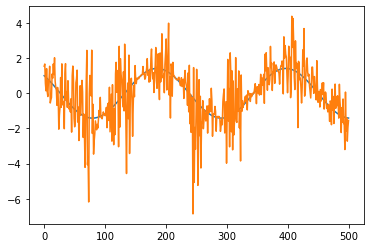

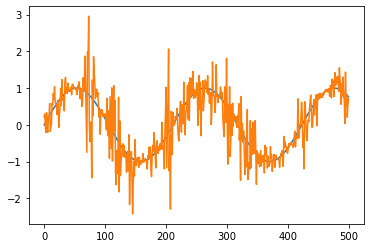

In [30]:
#plot the figures
left_boundary = 0
right_boundary = 500
t = np.arange(left_boundary,right_boundary)
plt.plot(t,Tau[left_boundary:right_boundary,0])
plt.plot(t,TauPred[left_boundary:right_boundary,0])
plt.show()

plt.plot(t,Tau[left_boundary:right_boundary,1])
plt.plot(t,TauPred[left_boundary:right_boundary,1])
plt.show()

In [ ]:

## Computing Jacobian in the case of stiff-ODE
states_dot_sym = sympy.Matrix([states_dot_sym[0], states_dot_sym[1], eom[0], eom[1]])
Jac = states_dot_sym.jacobian(states_sym)

## Please copy the string shown to the definition of equation in the function of Jacobian
for i in range(Jac.shape[0]):
    for j in range(Jac.shape[1]):
        print('Equation ' + str(i) + ',' + str(j) + ': ' + str(Jac[i,j]))
        print('\n')

def Jac(t, y):
    from numpy import cos, sin, sign
    x0, x1, x0_t, x1_t = y
    tau0, tau1 = 0, 0 
    J = np.zeros((4,4))
    J[0,0] = 0
    J[0,1] = 0
    J[0,2] = 1
    J[0,3] = 0

    J[1,0] = 0
    J[1,1] = 0
    J[1,2] = 0
    J[1,3] = 1

    J[2,0] = 1.0*(2.0*sin(x0)*sin(x1) + 2.0*cos(x0)*cos(x1))*(x0_t**2*sin(x0)*sin(x1) + x0_t**2*cos(x0)*cos(x1))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0) + 0.0625*(2.0*sin(x0)*sin(x1) + 2.0*cos(x0)*cos(x1))*(4.0*sin(x0)**2*sin(x1)*cos(x1) - 4.0*sin(x0)*sin(x1)**2*cos(x0) + 4.0*sin(x0)*cos(x0)*cos(x1)**2 - 4.0*sin(x1)*cos(x0)**2*cos(x1))*(tau1 + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) + 0.5*x0_t - 0.5*x1_t - 9.8*sin(x1))/(0.5*sin(x0)**2*sin(x1)**2 + sin(x0)*sin(x1)*cos(x0)*cos(x1) + 0.5*cos(x0)**2*cos(x1)**2 - 1)**2 + 1.0*(-2.0*sin(x0)*cos(x1) + 2.0*sin(x1)*cos(x0))*(tau1 + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) + 0.5*x0_t - 0.5*x1_t - 9.8*sin(x1))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0) - 2.0*(-x1_t**2*sin(x0)*sin(x1) - x1_t**2*cos(x0)*cos(x1) - 19.6*cos(x0))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0) - 0.125*(4.0*sin(x0)**2*sin(x1)*cos(x1) - 4.0*sin(x0)*sin(x1)**2*cos(x0) + 4.0*sin(x0)*cos(x0)*cos(x1)**2 - 4.0*sin(x1)*cos(x0)**2*cos(x1))*(tau0 - tau1 - 1.0*x0_t + 0.5*x1_t - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) - 19.6*sin(x0))/(0.5*sin(x0)**2*sin(x1)**2 + sin(x0)*sin(x1)*cos(x0)*cos(x1) + 0.5*cos(x0)**2*cos(x1)**2 - 1)**2
    J[2,1] = 1.0*(2.0*sin(x0)*sin(x1) + 2.0*cos(x0)*cos(x1))*(-x0_t**2*sin(x0)*sin(x1) - x0_t**2*cos(x0)*cos(x1) - 9.8*cos(x1))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0) + 0.0625*(2.0*sin(x0)*sin(x1) + 2.0*cos(x0)*cos(x1))*(-4.0*sin(x0)**2*sin(x1)*cos(x1) + 4.0*sin(x0)*sin(x1)**2*cos(x0) - 4.0*sin(x0)*cos(x0)*cos(x1)**2 + 4.0*sin(x1)*cos(x0)**2*cos(x1))*(tau1 + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) + 0.5*x0_t - 0.5*x1_t - 9.8*sin(x1))/(0.5*sin(x0)**2*sin(x1)**2 + sin(x0)*sin(x1)*cos(x0)*cos(x1) + 0.5*cos(x0)**2*cos(x1)**2 - 1)**2 + 1.0*(2.0*sin(x0)*cos(x1) - 2.0*sin(x1)*cos(x0))*(tau1 + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) + 0.5*x0_t - 0.5*x1_t - 9.8*sin(x1))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0) - 2.0*(x1_t**2*sin(x0)*sin(x1) + x1_t**2*cos(x0)*cos(x1))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0) - 0.125*(-4.0*sin(x0)**2*sin(x1)*cos(x1) + 4.0*sin(x0)*sin(x1)**2*cos(x0) - 4.0*sin(x0)*cos(x0)*cos(x1)**2 + 4.0*sin(x1)*cos(x0)**2*cos(x1))*(tau0 - tau1 - 1.0*x0_t + 0.5*x1_t - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) - 19.6*sin(x0))/(0.5*sin(x0)**2*sin(x1)**2 + sin(x0)*sin(x1)*cos(x0)*cos(x1) + 0.5*cos(x0)**2*cos(x1)**2 - 1)**2
    J[2,2] = 1.0*(2.0*sin(x0)*sin(x1) + 2.0*cos(x0)*cos(x1))*(2*x0_t*sin(x0)*cos(x1) - 2*x0_t*sin(x1)*cos(x0))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0)
    J[2,3] = -2.0*(-2*x1_t*sin(x0)*cos(x1) + 2*x1_t*sin(x1)*cos(x0))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0)

    J[3,0] = 1.0*(1.0*sin(x0)*sin(x1) + 1.0*cos(x0)*cos(x1))*(-x1_t**2*sin(x0)*sin(x1) - x1_t**2*cos(x0)*cos(x1) - 19.6*cos(x0))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0) + 0.25*(1.0*sin(x0)*sin(x1) + 1.0*cos(x0)*cos(x1))*(2.0*sin(x0)**2*sin(x1)*cos(x1) - 2.0*sin(x0)*sin(x1)**2*cos(x0) + 2.0*sin(x0)*cos(x0)*cos(x1)**2 - 2.0*sin(x1)*cos(x0)**2*cos(x1))*(tau0 - tau1 - 1.0*x0_t + 0.5*x1_t - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) - 19.6*sin(x0))/(0.5*sin(x0)**2*sin(x1)**2 + sin(x0)*sin(x1)*cos(x0)*cos(x1) + 0.5*cos(x0)**2*cos(x1)**2 - 1)**2 + 1.0*(-1.0*sin(x0)*cos(x1) + 1.0*sin(x1)*cos(x0))*(tau0 - tau1 - 1.0*x0_t + 0.5*x1_t - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) - 19.6*sin(x0))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0) - 2.0*(x0_t**2*sin(x0)*sin(x1) + x0_t**2*cos(x0)*cos(x1))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0) - 0.5*(2.0*sin(x0)**2*sin(x1)*cos(x1) - 2.0*sin(x0)*sin(x1)**2*cos(x0) + 2.0*sin(x0)*cos(x0)*cos(x1)**2 - 2.0*sin(x1)*cos(x0)**2*cos(x1))*(tau1 + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) + 0.5*x0_t - 0.5*x1_t - 9.8*sin(x1))/(0.5*sin(x0)**2*sin(x1)**2 + sin(x0)*sin(x1)*cos(x0)*cos(x1) + 0.5*cos(x0)**2*cos(x1)**2 - 1)**2
    J[3,1] = 1.0*(1.0*sin(x0)*sin(x1) + 1.0*cos(x0)*cos(x1))*(x1_t**2*sin(x0)*sin(x1) + x1_t**2*cos(x0)*cos(x1))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0) + 0.25*(1.0*sin(x0)*sin(x1) + 1.0*cos(x0)*cos(x1))*(-2.0*sin(x0)**2*sin(x1)*cos(x1) + 2.0*sin(x0)*sin(x1)**2*cos(x0) - 2.0*sin(x0)*cos(x0)*cos(x1)**2 + 2.0*sin(x1)*cos(x0)**2*cos(x1))*(tau0 - tau1 - 1.0*x0_t + 0.5*x1_t - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) - 19.6*sin(x0))/(0.5*sin(x0)**2*sin(x1)**2 + sin(x0)*sin(x1)*cos(x0)*cos(x1) + 0.5*cos(x0)**2*cos(x1)**2 - 1)**2 + 1.0*(1.0*sin(x0)*cos(x1) - 1.0*sin(x1)*cos(x0))*(tau0 - tau1 - 1.0*x0_t + 0.5*x1_t - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) - 19.6*sin(x0))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0) - 2.0*(-x0_t**2*sin(x0)*sin(x1) - x0_t**2*cos(x0)*cos(x1) - 9.8*cos(x1))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0) - 0.5*(-2.0*sin(x0)**2*sin(x1)*cos(x1) + 2.0*sin(x0)*sin(x1)**2*cos(x0) - 2.0*sin(x0)*cos(x0)*cos(x1)**2 + 2.0*sin(x1)*cos(x0)**2*cos(x1))*(tau1 + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) + 0.5*x0_t - 0.5*x1_t - 9.8*sin(x1))/(0.5*sin(x0)**2*sin(x1)**2 + sin(x0)*sin(x1)*cos(x0)*cos(x1) + 0.5*cos(x0)**2*cos(x1)**2 - 1)**2
    J[3,2] = -2.0*(2*x0_t*sin(x0)*cos(x1) - 2*x0_t*sin(x1)*cos(x0))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0)
    J[3,3] = 1.0*(1.0*sin(x0)*sin(x1) + 1.0*cos(x0)*cos(x1))*(-2*x1_t*sin(x0)*cos(x1) + 2*x1_t*sin(x1)*cos(x0))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0)
    return J


In [ ]:
## Debugging odeint vs solve_ivp

t = np.arange(0,5,0.01)
theta1 = np.random.uniform(-np.pi, np.pi)
theta2 = np.random.uniform(-np.pi, np.pi)
thetadot = np.random.uniform(0,0)
omega = np.random.uniform(-np.pi, np.pi)
  
y0=np.array([theta1, theta2, thetadot, thetadot])

from scipy.integrate import odeint
X = odeint(doublePendulum, y0, t, args=(omega,))
Xdot = doublePendulum(X,t,omega)

In [ ]:
## Debugging
device = 'cuda:0'
expr = np.array(expr)

i1 = np.where(expr == 'x0_t**2')[0][0]
i2 = np.where(expr == 'x1_t**2')[0][0]
i3 = np.where(expr == 'cos(x0)')[0][0]
i4 = np.where(expr == 'cos(x1)')[0][0]
i5 = np.where(expr == 'x0_t*x1_t*cos(x0)*cos(x1)')[0][0]
i6 = np.where(expr == 'x0_t*x1_t*sin(x0)*sin(x1)')[0][0]

xi_L = torch.zeros(len(expr), device=device)

#Creating library tensor
Zeta, Eta, Delta = LagrangianLibraryTensor(X,Xdot,expr,states,states_dot, scaling=False)
Zeta = Zeta.to(device)
Eta = Eta.to(device)
Delta = Delta.to(device)

xi_L[i1] = 1.0
xi_L[i2] = 0.5
xi_L[i3] = 19.62
xi_L[i4] = 9.81
xi_L[i5] = 1.0
xi_L[i6] = 1.0

xdot = torch.from_numpy(Xdot).to(device).float()
TauPred = ELforward(xi_L,Zeta,Eta,Delta,xdot,device).detach().cpu().numpy()
q_tt_pred = lagrangianforward(xi_L,Zeta,Eta,Delta,xdot,device).detach().cpu().numpy()
q_tt = Xdot[:,2:4]

t = np.arange(0,2000)
plt.plot(t,Tau[:2000,0])
plt.plot(t,TauPred[0,:2000])
plt.show()

plt.plot(t,Tau[:2000,1])
plt.plot(t,TauPred[1,:2000])
plt.show()

t = np.arange(0,2000)
plt.plot(t,q_tt[:2000,0])
plt.plot(t,q_tt_pred[0,:2000])
plt.show()

plt.plot(t,q_tt[:2000,1])
plt.plot(t,q_tt_pred[1,:2000])
plt.show()